Speech Emotion Recognition

In [3]:
# import libraries
import pandas as pd
import numpy as np

import os as os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

# import keras
# from keras.callbacks import ReduceLROnPlateau
# from keras.models import Sequential
# from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
# from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

Data Preparation
- As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
- We will use this dataframe to extract features for our model training.

In [4]:
# Paths for data
Crema = "/Users/sebastianbayne/Documents/WBS/Bootcamp/Final_Project /Datasets /Crema-D/AudioWAV"
Savee = "/Users/sebastianbayne/Documents/WBS/Bootcamp/Final_Project /Datasets /Savee/ALL/"
Tess = "/Users/sebastianbayne/Documents/WBS/Bootcamp/Final_Project /Datasets /Tess/TESS Toronto emotional speech set data"
Ravdess = "/Users/sebastianbayne/Documents/WBS/Bootcamp/Final_Project /Datasets /Ravdess/archive/audio_speech_actors_01-24"

In [15]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + "/" + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
1,fear,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
2,fear,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
3,angry,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
4,disgust,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...


In [24]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
1,angry,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
2,neutral,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
3,neutral,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
4,disgust,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...


In [7]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    if dir.startswith('.'):continue
    directories = os.listdir(Tess + '/' + dir)
    for file in directories:
        part = file.split('.')[0]
        if len(file.split('.'))<2:continue
        try:
            part = part.split('_')[2]
            if part=='ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + '/' + dir + '/' + file)
        except:
            print("Error occured at {}".format(file))
            continue

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Error occured at .DS_Store


,Emotions,Path
0,disgust,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
1,disgust,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
2,disgust,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
3,disgust,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
4,disgust,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...


In [8]:
Tess_df.Emotions.unique()

array(['disgust', 'surprise', 'happy', 'sad', 'neutral', 'fear', 'angry'],
      dtype=object)

In [9]:
Tess_df.query("Emotions == 'surprised'").iloc[0, 1]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
Tess_df.shape

(2800, 2)

In [ ]:
[x[-2:] for x in Tess_df.tail().Path.str.split("/")]

In [10]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,sad,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
1,sad,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
2,neutral,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
3,surprise,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
4,neutral,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...


In [16]:
# # creating Dataframe using all the 4 dataframes we created so far.
# data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
# data_path.to_csv("/Users/sebastianbayne/Documents/WBS/Bootcamp/Final_Project /Datasets/data_path.csv",index=False)
# data_path.head()

# Define the directory path
directory_path = "/Users/sebastianbayne/Documents/WBS/Bootcamp/Final_Project /Datasets "

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Concatenate and save the DataFrame to CSV
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
data_path.to_csv(os.path.join(directory_path, "data_path.csv"), index=False)
data_path.head()

,Emotions,Path
0,angry,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
1,fear,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
2,fear,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
3,angry,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...
4,disgust,/Users/sebastianbayne/Documents/WBS/Bootcamp/F...


Data Visualisation and Exploration¶
    First let's plot the count of each emotions in our dataset.

<Axes: title={'center': 'Count of Emotions'}, xlabel='Emotions', ylabel='count'>

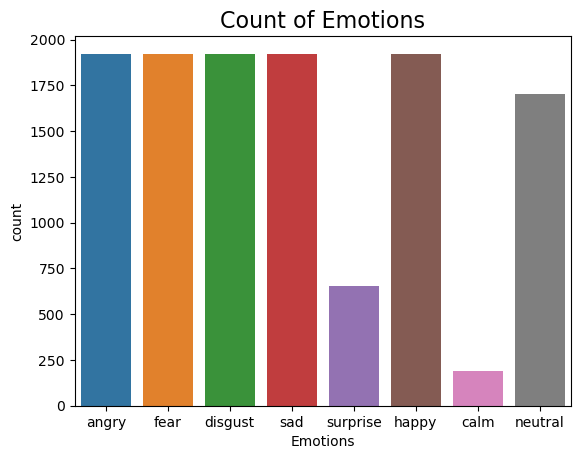

In [12]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path, x = 'Emotions')
# plt.ylabel('Count', size=12)
# plt.xlabel('Emotions', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)
# plt.show()

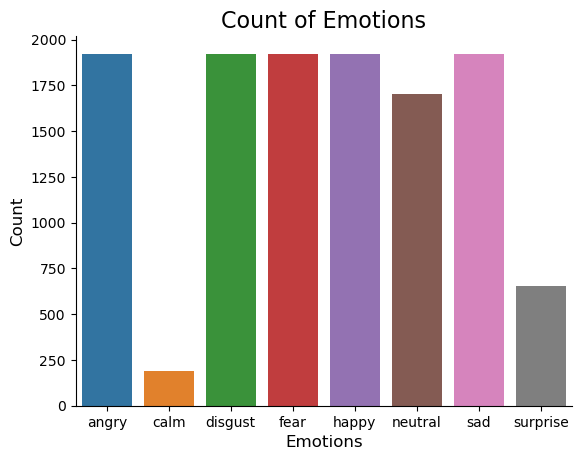

In [ ]:
data_path['Emotions'] = data_path['Emotions'].astype('category')

# Create the countplot
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [21]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

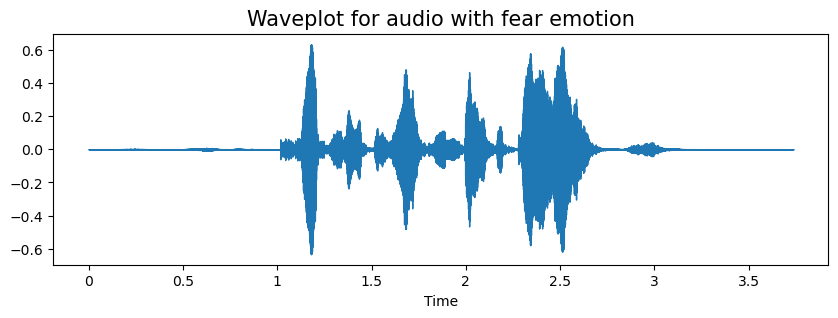

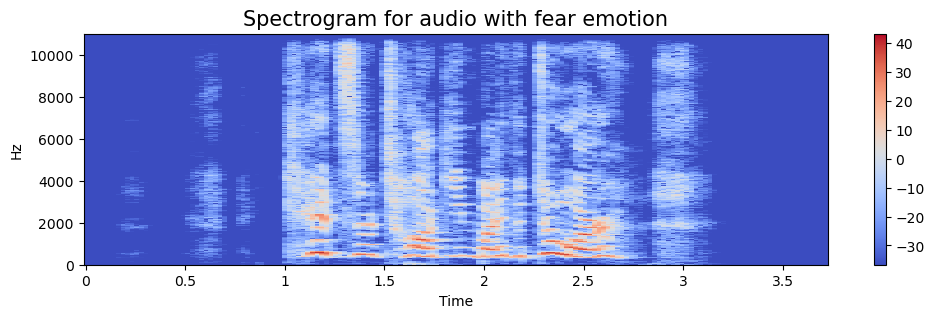

In [22]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
# Assuming 'data_path' is a DataFrame containing file paths and emotions
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Remove extra spaces from the file path
path = path.strip()

# Load the audio file
data, sampling_rate = librosa.load(path)

# Now you can proceed with your desired operations on the audio data
# create_waveplot(data, sampling_rate, emotion)
# create_spectrogram(data, sampling_rate, emotion)
# Audio(path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sebastianbayne/Documents/WBS/Bootcamp/Final_Project /Datasets /Ravdess/archive/audio_speech_actors_01-24Actor_16/03-01-06-02-01-02-16.wav'